In [40]:
import numpy as np
import pandas as pd
import math, random
import time as ti
from copy import deepcopy
from matplotlib.colors import LinearSegmentedColormap as lsc
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import matplotlib.backends.backend_pdf as pdf
import matplotlib
import scipy.stats

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

t0 = ti.time()
print(ti.strftime("%a, %d %b %Y %H:%M", ti.gmtime()))

Fri, 11 Oct 2019 00:50


In [41]:
# SIMULATED CHEMOKINESIS FUNCTION

def chemokinesis(movedf, width, radius_food, food_x, food_y, origin):
    '''
    Explore the arena until finding the food source. 
    Returns time spent searching (in seconds) and trajectory path (xlist, ylist)
    
    Model changes speed based on absolute concentration. 
    '''
    # Split the given speedlist into half by speed
    movedf_sorted = movedf.sort_values(by=["speed"], axis=0, ascending=True)
    movedf_sorted.reset_index(inplace=True)
    split_index = int(len(movedf_sorted)/2)
    slow_df = movedf_sorted.iloc[0:split_index].copy()
    fast_df = movedf_sorted.iloc[split_index:].copy()

    finish_check = False # Check if the food has been reached
    valid_check = False # Check if current position is within arena bounds
    
    if origin == None:
        while valid_check == False:
            x0, y0 = np.random.uniform(0, width), np.random.uniform(0, width)
            valid_check = check_if_valid(x0, y0, width)
    else:
        x0, y0 = origin[0], origin[1]

    xlist, ylist, prev_angle = [x0], [y0], random.uniform(0, 360)
    finish_check = check_if_done(x0, y0, radius_food, food_x, food_y)
    
    # Continue moving until food has been found
    while finish_check == False:
        valid_check = False
        
        curr_concentration = get_concentration(x0, y0, width/2, radius_food, food_x, food_y)
        p = get_prob(curr_concentration)
        
        while valid_check == False:
            p_rand = np.random.uniform(0, 100)
            if p_rand <= p:
                rand = slow_df.sample(n=1)
                stepsize = rand['speed'].values[0]
                angsize = rand['angle_delta'].values[0]
                angle = get_angle(angsize, prev_angle)
            else:
                rand = fast_df.sample(n=1)
                stepsize = rand['speed'].values[0]
                angsize = rand['angle_delta'].values[0]
                angle = get_angle(angsize, prev_angle)

            x1, y1 = get_next_xy(x0, y0, angle, stepsize)
            valid_check = check_if_valid(x1, y1, width)

        xlist.append(x1)
        ylist.append(y1)

        x0, y0 = deepcopy(x1), deepcopy(y1) # update saved previous point 
        prev_angle = deepcopy(angle)
        curr_concentration = get_concentration(x0, y0, width/2, radius_food, food_x, food_y)
        finish_check = check_if_done(x0, y0, radius_food, food_x, food_y)
        
    return(len(xlist)/2, xlist, ylist)

# HELPER FUNCTIONS FOR CHEMOKINESIS MODEL

def check_if_valid(x, y, width):
    ''' Returns bool whether or not this point is valid '''
    radius = width/2
    leg1 = np.abs(radius-y)
    leg2 = np.abs(radius-x)
    distance = np.hypot(leg1, leg2)
    if distance > radius:
        return False
    return True

def get_prob(c):
    ''' Returns the probability of choosing the preferred dataset
        as a function of concentration. 
    '''
    c = max(1e-12, c)
    c = min(100-1e-12, c)
    p = 100/(1+np.exp(-0.25*(c-50)))
    return p

def get_angle(angsize, prev_angle):
    ''' Returns random angle between 0 and 360 '''
    return prev_angle + angsize

def get_next_xy(x0, y0, angle, stepsize):
    ''' Return next point as a function of angle and speed '''
    radian = np.deg2rad(angle)
    x1 = x0 + stepsize * math.cos(radian)
    y1 = y0 + stepsize * math.sin(radian)
    return x1, y1

def check_if_done(x0, y0, radius_food, food_x, food_y):
    ''' Returns true if the animal has found the food '''
    leg1 = np.abs(food_x-x0)
    leg2 = np.abs(food_y-y0)
    distance = np.hypot(leg1, leg2)
    if distance <= radius_food:
        return True
    return False

def get_concentration_based_on_distance(distance, a, b):
    ''' Use best fit line to return concentration estimate '''
    if distance <= 0:
        c = 100
    elif distance <= np.hypot(80, 30):
        c = np.exp(b)*np.exp(a*distance)
    else:
        c = 0
    return(c)

def get_concentration(x, y, radius, radius_food, food_x, food_y, 
                      a=-0.08046986117494856, b=4.897119830335053):
    leg1 = np.abs(food_x-x)
    leg2 = np.abs(food_y-y)
    distance = np.hypot(leg1, leg2)
    distance = distance-radius_food 
    c = get_concentration_based_on_distance(distance, a, b)
    return(c)

def get_radius_food(width, perc_area=0.03):
    '''
    perc_area = proportion of arena that should be taken up by food. width = width of arena. 
    '''
    r = width/2
    arena_a = math.pi * r * r
    food_a = arena_a * perc_area
    food_r = np.sqrt(food_a / math.pi)
    return food_r

def run_simulations(n_trials, widths, savename, movedf, function, origin=None):
    # Initialize DF to save values into
    colnames = [str(int(x)) for x in widths]
    rownames = np.arange(0, n_trials)
    rownames = [str(int(x))+'_trial' for x in rownames]
    df_out = pd.DataFrame(index=rownames, columns=colnames)
    
    for width in widths: 
        tlist = []
        radius_food = get_radius_food(width)
        food_x = width/2 # x position of food center
        food_y = width/2 # y position of food center

        for n in range(n_trials):
            timecount, xlist, ylist = function(movedf, width, radius_food, food_x, food_y, origin)
            tlist.append(timecount)

        df_out[str(width)] = tlist

    df_out.to_csv(savename, index=False)
    df_out.head()


Mean angle delta: 0.29
Mean speed (mm/f): 1.14
Mean angle delta: 0.23
Mean speed (mm/f): 1.3


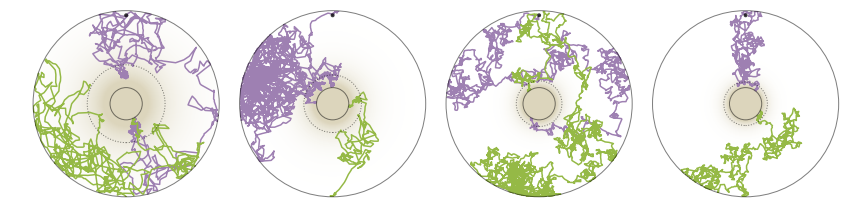

In [3]:
fig = plt.figure(figsize=(12, 3))
savename = "./figures/5.pdf"

grid = matplotlib.gridspec.GridSpec(1, 4)
axA = fig.add_subplot(grid[0, 0], aspect="equal", facecolor="None")
axB = fig.add_subplot(grid[0, 1], aspect="equal", facecolor="None")
axC = fig.add_subplot(grid[0, 2], aspect="equal", facecolor="None")
axD = fig.add_subplot(grid[0, 3], aspect="equal", facecolor="None")
fifty = 12.241810915582668
cmap = lsc.from_list("cmap_food", ["#ffffff", '#dcd5bc'])

df = pd.read_csv("./data/trajectories/summary/modeling_Fed_acclimate_all_animals.csv")
df.dropna(subset=['angle_delta', 'speed_mm_s'], inplace=True, axis=0)
df['speed'] = df['speed_mm_s']/2
print("Mean angle delta:", round(np.mean(df['angle_delta'].tolist()), 2))
print("Mean speed (mm/f):", round(np.mean(df['speed'].tolist()), 2))

for r, ax in zip([50, 90, 170, 200], [axA, axB, axC, axD]):
    width = r*2
    radius_food = get_radius_food(width)
    ax.set_xlim(0, width)
    ax.set_ylim(0, width)
    ax.axis("off")
    
    t, x_data, y_data = chemokinesis(df, width, radius_food, r, r, (r, r*1.95))
    ax.plot(x_data, y_data, color='#9e80b2', zorder=20)
    
    for rr in np.linspace(r, r*2, 100)[::-1]:
        conc = get_concentration(rr, r, r, radius_food, r, r)
        color = cmap(conc/100)
        ax.add_patch(pch.Circle((r, r), rr-r, facecolor=color, edgecolor=None, zorder=1))
        
    ax.add_patch(pch.Circle((r, r), radius_food, facecolor=color, zorder=25, alpha=0.75))
    ax.add_patch(pch.Circle((r, r), radius_food, facecolor="None", edgecolor='k', zorder=25, alpha=0.5))
    ax.add_patch(pch.Circle((r, r), r, facecolor="None", edgecolor='k', clip_on=False, zorder=25, alpha=0.5))
    ax.add_patch(pch.Circle((r, r), radius_food+fifty, facecolor="None", linestyle="dotted",
                            edgecolor='k', clip_on=False, zorder=25, alpha=0.5))
    ax.scatter(x_data[0], y_data[0], marker="o", s=16, color="k", 
               lw=0, edgecolor="None", alpha=0.75, zorder=30, clip_on=False)

    
df = pd.read_csv("./data/trajectories/summary/modeling_Starved_acclimate_all_animals.csv")
df.dropna(subset=['angle_delta', 'speed_mm_s'], inplace=True, axis=0)
df['speed'] = df['speed_mm_s']/2
print("Mean angle delta:", round(np.mean(df['angle_delta'].tolist()), 2))
print("Mean speed (mm/f):", round(np.mean(df['speed'].tolist()), 2))
for r, ax in zip([50, 90, 170, 200], [axA, axB, axC, axD]):
    width = r*2
    radius_food = get_radius_food(width)
    ax.set_xlim(0, width)
    ax.set_ylim(0, width)
    ax.axis("off")
    
    t, x_data, y_data = chemokinesis(df, width, radius_food, r, r, (r, 0.05))
    ax.plot(x_data, y_data, color='#95b946', zorder=20)
    
# SET BOUNDARIES AND SAVE FIGURE -----------------------------------------------
plt.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
pp = pdf.PdfPages(savename, keep_empty=False)
pp.savefig(fig)
pp.close()
plt.show()

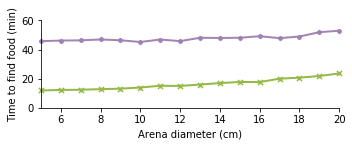

fed animals slope, intercept: 
22.909374264705885 2579.0851029411765

starved animals slope, intercept: 
45.26519852941176 412.8242683823529

difference slope, intercept: 
-22.355824264705884 2166.2608345588237

Large arena size means (50, 100, 150cm diameter)
[1.735975, 4.289032777777778, 8.324199583333334] hours
[1.234823888888889, 4.24966125, 7.480811944444444] hours


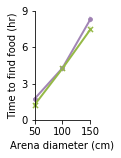

In [51]:
savename = './figures/simulation_results.pdf'

#### SMALL ARENA SIZES PLOT ####

df1 = pd.read_csv('./data/simulation_results/1000_simulations_fed.csv')
widths = df1.columns.astype(int).tolist()
widths = [int(x) for x in widths]
means = df1.mean(axis=0).tolist()
sterr = df1.sem(axis=0).tolist()
    
df2 = pd.read_csv('./data/simulation_results/1000_simulations_starved.csv')
widths2 = df2.columns.astype(int).tolist()
widths2 = [int(x) for x in widths2]
means2 = df2.mean(axis=0).tolist()
sterr2 = df2.sem(axis=0).tolist()

x, y, s = [w/10 for w in widths], means, sterr
x2, y2, s2 = [w/10 for w in widths2], means2, sterr2

fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)

ax.scatter(x, y, alpha=1, clip_on=False, color='#9e80b2', marker="o", s=14, label=None)
ax.plot(x, y, alpha=11, clip_on=False, lw=2, color='#9e80b2', label=None)
ax.errorbar(x, y, clip_on=False, yerr=s, xerr=0, fmt='|', alpha=0.25, color='#9e80b2', label=None)

ax.scatter(x2, y2, clip_on=False, alpha=1, color='#95b946', marker="x", s=26, label=None)
ax.plot(x2, y2, clip_on=False, alpha=1, lw=2, color='#95b946', label=None)
ax.errorbar(x2, y2, clip_on=False, yerr=s2, xerr=0, fmt='|', alpha=0.25, color='#95b946', label=None)

ax.set_ylim(0, 3500)
ax.set_yticks(np.arange(0, 3601, 1200))
ax.set_yticklabels([int(x) for x in np.arange(0, 3601/60, 1200/60)])
ax.set_xlim(5, 20)
ax.set_ylabel("Time to find food (min)")
ax.set_xlabel("Arena diameter (cm)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
matplotlib.rcParams['pdf.fonttype'] = 42
fig.subplots_adjust(wspace=0.1, hspace=0.1)
pp = pdf.PdfPages(savename, keep_empty=False)
pp.savefig(fig)
pp.close()
plt.show()

slope, intercept, rvalue, pvalue, stderror = scipy.stats.linregress(x, y)
print('fed animals slope, intercept: ')
print(slope, intercept)
# print(rvalue, pvalue)

slope, intercept, rvalue, pvalue, stderror = scipy.stats.linregress(x2, y2)
print('\nstarved animals slope, intercept: ')
print(slope, intercept)
# print(rvalue, pvalue)

y3 = [xx-xx2 for xx, xx2 in zip(y, y2)]
slope, intercept, rvalue, pvalue, stderror = scipy.stats.linregress(x, y3)
print('\ndifference slope, intercept: ')
print(slope, intercept)
# print(rvalue, pvalue)

###################################

#### LARGE ARENA SIZES PLOT ####
savename = "./figures/5_mini.pdf"

df1 = pd.read_csv('./data/simulation_results/1000_simulations_fed_large.csv')
widths = df1.columns.astype(int).tolist()
widths = [int(x) for x in widths]
means = df1.mean(axis=0).tolist()
sterr = df1.sem(axis=0).tolist()
print('\nLarge arena size means (50, 100, 150cm diameter)')
print([x/60/60 for x in means], 'hours')
    
df2 = pd.read_csv('./data/simulation_results/1000_simulations_starved_large.csv')
widths2 = df2.columns.astype(int).tolist()
widths2 = [int(x) for x in widths2]
means2 = df2.mean(axis=0).tolist()
sterr2 = df2.sem(axis=0).tolist()
print([x/60/60 for x in means2], 'hours')

x, y, s = [w/10 for w in widths], means, sterr
x2, y2, s2 = [w/10 for w in widths2], means2, sterr2

fig = plt.figure(figsize=(1, 2))
ax = fig.add_subplot(111)

ax.scatter(x, y, alpha=1, clip_on=False, color='#9e80b2', marker="o", s=14, label=None)
ax.plot(x, y, alpha=11, clip_on=False, lw=2, color='#9e80b2', label=None)
ax.errorbar(x, y, yerr=s, clip_on=False, xerr=0, fmt='|', alpha=0.25, color='#9e80b2', label=None)

ax.scatter(x2, y2, alpha=1, clip_on=False, color='#95b946', marker="x", s=26, label=None)
ax.plot(x2, y2, alpha=1, clip_on=False, lw=2, color='#95b946', label=None)
ax.errorbar(x2, y2, clip_on=False, yerr=s2, xerr=0, fmt='|', alpha=0.25, color='#95b946', label=None)

ax.set_ylim(0, 9*60*60+1)
ax.set_yticks(np.arange(0, 9*60*60+1, 3*60*60))
ax.set_yticklabels([int(x) for x in np.arange(0, 9*60*60/60/60+1, 3*60*60/60/60)])
ax.set_xlim(50, 150)
ax.set_ylabel("Time to find food (hr)")
ax.set_xlabel("Arena diameter (cm)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
matplotlib.rcParams['pdf.fonttype'] = 42
fig.subplots_adjust(wspace=0.1, hspace=0.1)
pp = pdf.PdfPages(savename, keep_empty=False)
pp.savefig(fig)
pp.close()
plt.show()
###################################

In [25]:
# Print mean time for larger container sizes

df1 = pd.read_csv('./data/simulation_results/1000_simulations_fed_large.csv')
widths = df1.columns.astype(int).tolist()
widths = [int(x) for x in widths]
means = df1.mean(axis=0).tolist()
sterr = df1.sem(axis=0).tolist()
print([x/60/60 for x in means], 'hours')
    
df2 = pd.read_csv('./data/simulation_results/1000_simulations_starved_large.csv')
widths2 = df2.columns.astype(int).tolist()
widths2 = [int(x) for x in widths2]
means2 = df2.mean(axis=0).tolist()
sterr2 = df2.sem(axis=0).tolist()
print([x/60/60 for x in means2], 'hours')

[1.735975, 4.289032777777778, 8.324199583333334] hours
[1.234823888888889, 4.24966125, 7.480811944444444] hours


A_time_move 0.02612562534741523 0.8453837597330367
A_time_wall 0.13737486095661847 0.9727474972191325


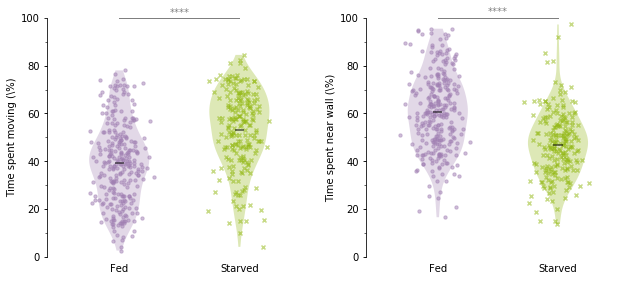

In [50]:
df = pd.read_csv('./data/trajectories/summary/cleaned_animal_analyses.csv')
savename = "./figures/5_starved_fed.pdf"

feddata = df[(df["A_starved"] == "no")]
starveddata = df[(df["A_starved"] == "1day")]

tests = ["A_time_move", "A_time_wall"]
for test in tests:
    print(test, df[test].min(), df[test].max())
    
fig = plt.figure(figsize=(9, 4))
ax2 = fig.add_subplot(121, facecolor="None")
ax3 = fig.add_subplot(122, facecolor="None")

colors = ["#a07fb2", "#90b60e"]
markers = ["o", "x"]
markersizes = [11, 16]
datums = ["A_time_move", "A_time_wall"]

# P values double checked 
ps = ["****", "****"]

ax2.set_ylabel("Time spent moving (\%)")
ax3.set_ylabel("Time spent near wall (\%)")

for i, (datum, ax) in enumerate(zip(datums, [ax2, ax3])):
    data = [feddata[datum].values, starveddata[datum].values]
    jitter = [np.random.normal(scale=0.1, size=len(feddata)), np.random.normal(scale=0.1, size=len(starveddata))]
    parts = ax.violinplot(data, showmeans=False, showmedians=False,showextrema=False)

    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.3)

    for i, (j, d) in enumerate(zip(jitter, data)):
        j = [x+i+1 for x in j]
        ax.scatter(j, d, alpha=0.5, color=colors[i], zorder=5, s=markersizes[i], 
                    marker=markers[i])

    ch = 0.03
    ax.plot([1-ch, 1+ch], [np.mean(data[0])]*2, color="k", alpha=0.5, lw=2, zorder=20)
    ax.plot([2-ch, 2+ch], [np.mean(data[1])]*2, color="k", alpha=0.5, lw=2, zorder=20)
    
    up, pchv = 1, ax.get_ylim()[1]*0.025
    ax.plot([1, 2], [up, up], color="k", lw=1, clip_on=False, alpha=0.5)
    ax.text(1.5, up+pchv, ps[i], alpha=0.5, clip_on=False, ha="center", va="center", zorder=12)
    ax.set_xticks(np.arange(1, 3, 1))
    ax.set_xticklabels(["Fed", "Starved"])
    ax.xaxis.set_ticks_position('none') 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0.4, 2+(1-0.4))
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1, 0.1), minor=True)
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])

# SET BOUNDARIES AND SAVE FIGURE -----------------------------------------------
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
pp = pdf.PdfPages(savename, keep_empty=False)
pp.savefig(fig)
pp.close()
plt.show()

xmin, xmax =  0.0 35.2494003564
ymin, ymax =  -180 180


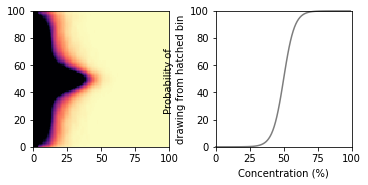

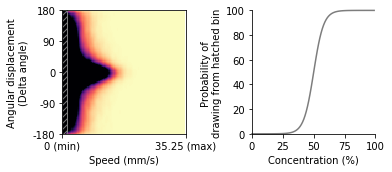

In [10]:
df = pd.read_csv("./data/trajectories/summary/modeling_Starved_acclimate_all_animals.csv")
df = df.dropna(axis=0)
anglelist = df["angle_delta"]
speedlist = df["speed_mm_s"]
q2_speedlist = sorted(speedlist)[int(len(speedlist)/2)]

kernel = scipy.stats.gaussian_kde(np.vstack([speedlist, anglelist]))
xmin, xmax = min(speedlist), max(speedlist)
ymin, ymax = -180, 180
print("xmin, xmax = ", xmin, xmax)
print("ymin, ymax = ", ymin, ymax)

x, y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([x.ravel(), y.ravel()])
z = np.reshape(kernel(positions).T, x.shape)

savename = './figures/PDF.pdf'
fig = plt.figure(figsize=(6, 2.5))

ax4 = fig.add_subplot(121)
axA = fig.add_subplot(122, aspect="equal")

c = "#7d7d7d"
xrange = max(speedlist)-min(speedlist)

axA.set_xlim(0, 100)
axA.set_ylim(0, 100)
xs = np.arange(0, 100, 1)
ys = [100/(1+np.exp(-0.25*(x-50))) for x in xs]
axA.plot(xs, ys, color=c, clip_on=False)
axA.set_ylabel("Probability of \ndrawing from hatched bin")
axA.set_xticks([0, 25, 50, 75, 100]) 
axA.set_xlabel("Concentration (%)")

ax4.set_ylim(0, 100)
ax4.set_xlim(0, 100)
ax4.imshow(np.rot90(z), cmap="magma_r", aspect="equal", vmin=0, vmax=0.0001)
ax4.add_patch(pch.Rectangle((0, -200), width=q2_speedlist*100/xrange, height=400, facecolor='none',
                            edgecolor=c, hatch='////'))
ax4.set_yticks(np.arange(0, 101, 25))
ax4.set_yticklabels([int(x) for x in np.arange(-180, 181, 360/4)])
ax4.set_xticks(np.arange(0, 101, 100))
ax4.set_xticklabels(['0 (min)', '35.25 (max)'])

ax4.set_xlabel("Speed (mm/s)")
ax4.set_ylabel("Angular displacement\n(Delta angle)")
axA.spines['right'].set_visible(False)
axA.spines['top'].set_visible(False)

plt.tight_layout()
matplotlib.rcParams['pdf.fonttype'] = 42
fig.subplots_adjust(wspace=0.1, hspace=0.1)
pp = pdf.PdfPages(savename, keep_empty=False)
pp.savefig(fig)
pp.close()
plt.show()

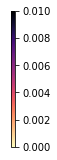

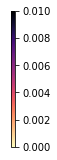

In [12]:
savename = './figures/colorbar.pdf'
fig = plt.figure(figsize=(0.075, 2.5))
ax1 = fig.add_subplot(111)

cmap = matplotlib.cm.magma_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.0001*100)
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

matplotlib.rcParams['pdf.fonttype'] = 42
fig.subplots_adjust(wspace=0.1, hspace=0.1)
pp = pdf.PdfPages(savename, keep_empty=False)
pp.savefig(fig)
pp.close()
plt.show()